%load_ext autoreload
%autoreload 2

In [68]:
import pandas as pd
import numpy as np
import torch

import seaborn as sns
import plotly.graph_objects as go

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
import src.data_handler as data_handler
from src.processing.raw_data_cleaning import prepare_graph_for_participant

/home/julien-rsbrg/venv/venv_semantic_to_liking/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = data_handler.load_data()

== Load Data: start ==
== Load Data: end ==


In [46]:
df = {'word': [4,1,2,3]}
pd.DataFrame(df).T

,0,1,2,3
word,4,1,2,3


In [141]:
data["two_experienced"] = data.apply(lambda row: (row["word1_experience"] > 0) * (row["word2_experience"] > 0),axis=1)
data["two_not_experienced"] = data.apply(lambda row: (row["word1_experience"] == 0) * (row["word2_experience"] == 0),axis=1)
data["exp_unexp"] = ~((data["two_not_experienced"] == 1) + (data["two_experienced"] == 1) )


data[data["two_experienced"] == 1]['senenceBERT_mpnet_similarity'].mean(), data[data["two_experienced"] == 1]['senenceBERT_mpnet_similarity'].std(),data[data["exp_unexp"] == 1]['senenceBERT_mpnet_similarity'].mean(), data[data["exp_unexp"] == 1]['senenceBERT_mpnet_similarity'].std()

(0.24915085574274226,
 0.11460586518841362,
 0.2470070092419055,
 0.10986778779998783)

In [139]:
data["exp_unexp"] 

0        -2
1        -2
2        -2
3        -1
4        -2
         ..
198235   -2
198236   -2
198237   -2
198238   -2
198239   -2
Name: exp_unexp, Length: 198240, dtype: int64

In [129]:
data['z - senenceBERT_mpnet_similarity'] = (data['senenceBERT_mpnet_similarity'] - data['senenceBERT_mpnet_similarity'].mean())/data['senenceBERT_mpnet_similarity'].std()

In [127]:
data[(data["two_experienced"] == 1) * (data["depression"] == 1)]['senenceBERT_mpnet_similarity'].mean(), data[(data["two_experienced"] == 1) * (data["depression"] == 1)]['senenceBERT_mpnet_similarity'].std()

(0.2497295596391147, 0.11402031554423075)

In [128]:
data[(data["two_experienced"] == 1) * (data["depression"] == 0)]['senenceBERT_mpnet_similarity'].mean(),data[(data["two_experienced"] == 1) * (data["depression"] == 0)]['senenceBERT_mpnet_similarity'].std()

(0.24870640919016263, 0.11505225874396997)

In [135]:
data[(data["two_experienced"] == 1) * (data["depression"] == 1)]['z - senenceBERT_mpnet_similarity'].mean(), data[(data["two_experienced"] == 1) * (data["depression"] == 1)]['z - senenceBERT_mpnet_similarity'].std()

(0.007007178241225449, 1.0050356911480698)

In [134]:
data[(data["two_experienced"] == 1) * (data["depression"] == 0)]['z - senenceBERT_mpnet_similarity'].mean(),data[(data["two_experienced"] == 1) * (data["depression"] == 0)]['z - senenceBERT_mpnet_similarity'].std()

(-0.002011413872844891, 1.0141317872430953)

In [124]:
data["two_not_experienced"] = data.apply(lambda row: (row["word1_experience"] == 0) * (row["word2_experience"] == 0),axis=1)

data[data["two_not_experienced"] == 1]['senenceBERT_mpnet_similarity'].mean()

0.2590095492718229

In [ ]:
# should be elsewhere, TODO clean data structure

from sentence_transformers import SentenceTransformer

#model = SentenceTransformer('all-MiniLM-L6-v2')
model = SentenceTransformer("all-mpnet-base-v2")

def create_embeddings(text):
    return model.encode(text)

words = sorted(list(set(data["word1"].unique()) |  set(data["word2"].unique())))

word_to_embeddings = {}
for i,w in enumerate(words):
    print(f"{i + 1} / {len(words)}") 
    emb = create_embeddings(w)
    word_to_embeddings[w] = list(emb)

pd.DataFrame(word_to_embeddings).to_csv('data/processed/node_data/word_to_embeddings_MPNet.csv')

In [ ]:
participant_graph, translator_word_to_index = prepare_graph_for_participant(data=data, 
                                                     participant_id=1, 
                                                     sim_used="original")

Test function convert_table_to_graph
Data(x=[60, 2], edge_index=[2, 3540], edge_attr=[3540, 1], y=[60, 1], x_names=[2], edge_attr_names=[1], y_names=[1], train_mask=[60], val_mask=[60])
validate: True
is undirected: True
has_self_loop: tensor(False)
end Test function convert_table_to_graph


/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

Data(x=[60, 2], edge_index=[2, 3540], edge_attr=[3540, 1], y=[60, 1], x_names=[2], edge_attr_names=[1], y_names=[1], train_mask=[60], val_mask=[60])

In [ ]:
def add_edge_L2_dist_to_graph(participant_graph, translator_word_to_index, word_to_embeddings = word_to_embeddings):

    translator_index_to_word_emb = {v:np.array(word_to_embeddings[k]) for k,v in translator_word_to_index.items()} # will have to add .values when loading 
    
    edge_L2_dist = []
    for edge_i in range(participant_graph.edge_index.size(1)):
        sender_id,receiver_id = participant_graph.edge_index[:,edge_i]
        sender_id,receiver_id = int(sender_id), int(receiver_id)
        L2_dist = np.linalg.norm(translator_index_to_word_emb[receiver_id] - translator_index_to_word_emb[sender_id])
        edge_L2_dist.append([L2_dist])

    participant_graph.edge_L2_dist = torch.Tensor(edge_L2_dist)
    return participant_graph

participant_graph = add_edge_L2_dist_to_graph(participant_graph=participant_graph,translator_word_to_index=translator_word_to_index)
participant_graph

Data(x=[60, 2], edge_index=[2, 3540], edge_attr=[3540, 1], y=[60, 1], x_names=[2], edge_attr_names=[1], y_names=[1], train_mask=[60], val_mask=[60], edge_L2_dist=[3540, 1])

In [ ]:
participant_graph.x_names,participant_graph.edge_attr_names,participant_graph.num_nodes

(['liking', 'experience'], ['_sim'], 60)

In [6]:
# start with random clusters (later take cs = x[:,1] > 0)
cs = np.random.randint(0,2,size=participant_graph.num_nodes)
cs

array([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0])

assumes only 2 clusters, if there are others, they are omitted
can use torch_geometric.datasets.InfectionDataset for validation

params:
cluster_id_start
cluster_id_end

% what if inf? no path between the two... 

ALGO 1

distance_to_other_cluster_nodes = np.zeros((len(x),len(x))) 
weighted_distance_to_other_cluster_nodes = np.zeros((len(x),len(x)))

for node_i in cluster_id_start:
    for node_j in cluster_id_end:
        shortest_path_ij = shortest_path(node_i,node_j,graph) # get the nodes ids [], get the weights []
        is_cluster_end = shortest_path_ij[0] == cluster_id_end # if there is another cluster on the way before, it is omitted
        distance_to_cluster_end = np.where(is_cluster_end)[0][0]
        weighted_distance_to_cluster_end = sum(shortest_path_ij[:distance_to_cluster_end]

        distance_to_other_cluster_nodes[node_i, node_j] = distance_to_cluster_end
        weighted_distance_to_other_cluster_nodes[node_i, node_j] = weighted_distance_to_cluster_end

distance_to_other_cluster = np.min(distance_to_other_cluster_nodes,axis=1)
weighted_distance_to_other_cluster = np.min(weighted_distance_to_other_cluster_nodes,axis=1)

mean_distance_to_other_cluster = np.mean(distance_to_other_cluster)
mean_weighted_distance_to_other_cluster = np.mean(weighted_distance_to_other_cluster)


ALGO 2

Take random walks of length, length of the graph (or bounded in param)... and compute the average 


In [10]:
from torch_geometric.data import Data
from typing import Iterable

def shortest_path_djikstra(node_start:int,edge_index:np.array,edge_weight:Iterable,num_nodes:int|None = None):
    assert node_start <= np.max(np.max(edge_index),num_nodes), f"There is no edge connected to node_start or the number of nodes ({num_nodes}) given is wrong..."
    
    _num_nodes = num_nodes
    if num_nodes is None:
        _num_nodes = np.max(edge_index)+1
        
    distance_from_start = np.inf * np.ones(_num_nodes)
    distance_from_start[node_start] = 0

    shortest_path_from_start = {node_id:{"edge_index":[],"edge_weight":[]} for node_id in range(_num_nodes)}

    segments_to_check = [(0,node_start)]
    while len(segments_to_check):
        #print("len(segments_to_check):",len(segments_to_check))
        selected_segment = segments_to_check.pop(-1)
        sending_edges_mask = edge_index[0,:] == selected_segment[1]

        receiving_neighbor_nodes = edge_index[1,sending_edges_mask] 
        neighbor_distances = edge_weight[sending_edges_mask]

        for edge_local_id,node_id in enumerate(receiving_neighbor_nodes):
            current_path_distance = selected_segment[0] + neighbor_distances[edge_local_id]
            if distance_from_start[node_id] > current_path_distance:
                distance_from_start[node_id] =  current_path_distance
                segments_to_check.append((distance_from_start[node_id],node_id))
                shortest_path_from_start[node_id]["edge_index"] = shortest_path_from_start[selected_segment[1]]["edge_index"] + [[selected_segment[1],node_id]] 
                shortest_path_from_start[node_id]["edge_weight"] = shortest_path_from_start[selected_segment[1]]["edge_weight"] + [neighbor_distances[edge_local_id]] 
    return distance_from_start, shortest_path_from_start

edge_index = np.array([[0,0,0,0,1,2,2,3,4],
                       [1,2,3,4,6,3,5,5,6]])
edge_weight = np.array([2,2,4,1,2,1,5,1,2])
true_values = np.array([0,2,2,3,1,4,3])

assert np.allclose(true_values,shortest_path_djikstra(0,edge_index,edge_weight)[0])


In [11]:
shortest_path_djikstra(0,edge_index,edge_weight)

(array([0., 2., 2., 3., 1., 4., 3.]),
 {0: {'edge_index': [], 'edge_weight': []},
  1: {'edge_index': [[0, 1]], 'edge_weight': [2]},
  2: {'edge_index': [[0, 2]], 'edge_weight': [2]},
  3: {'edge_index': [[0, 2], [2, 3]], 'edge_weight': [2, 1]},
  4: {'edge_index': [[0, 4]], 'edge_weight': [1]},
  5: {'edge_index': [[0, 2], [2, 3], [3, 5]], 'edge_weight': [2, 1, 1]},
  6: {'edge_index': [[0, 4], [4, 6]], 'edge_weight': [1, 2]}})

In [71]:
import copy 

def shortest_path_to_cluster_djikstra(node_start:int,edge_index:np.array,edge_weight:Iterable,cluster:Iterable[bool],num_nodes:int|None = None,exclude_itself:bool=True):
    """
    shortest path from node_start to a node belonging to cluster (set to True).

    Parameters
    ----------
    - exclude_itself: (bool)
        If True and node_start in cluster, removes node_start from the cluster identification and computes the distance to the nodes of the same cluster
    """
    _cluster = copy.copy(cluster)
    if exclude_itself:
        _cluster[node_start] = False

    node_ids_cluster = np.where(_cluster)[0]
    
    if node_start in node_ids_cluster:
        return 0, {node_start: {'edge_index': [], 'edge_weight': []}}
    elif len(node_ids_cluster) == 0:
        return np.nan, dict() 
    else:
        distances_from_start, shortest_path_from_start = shortest_path_djikstra(node_start,edge_index,edge_weight,num_nodes=num_nodes)
        closest_node_id_cluster = node_ids_cluster[np.argmin(distances_from_start[node_ids_cluster])]

        shortest_path_to_cluster = {closest_node_id_cluster: shortest_path_from_start[closest_node_id_cluster]}
        return distances_from_start[closest_node_id_cluster],shortest_path_to_cluster

def mean_shortest_distance_to_cluster_djikstra(node_start:int,edge_index:np.array,edge_weight:Iterable,cluster:Iterable[bool],num_nodes:int|None = None,exclude_itself:bool=True):
    """
    mean shortest distance from node_start to a node belonging to cluster (set to True).
    """
    _cluster = copy.copy(cluster)
    if exclude_itself:
        _cluster[node_start] = False
    node_ids_cluster = np.where(_cluster)[0]

    distances_from_start, _ = shortest_path_djikstra(node_start,edge_index,edge_weight,num_nodes=num_nodes)
    return np.mean(distances_from_start[node_ids_cluster])


def mean_leaps_shortest_path_to_cluster_djikstra(node_start:int,edge_index:np.array,edge_weight:Iterable,cluster:Iterable[bool],num_nodes:int|None = None,exclude_itself:bool=True):
    """
    mean shortest distance from node_start to a node belonging to cluster (set to True).
    """
    _cluster = copy.copy(cluster)
    if exclude_itself:
        _cluster[node_start] = False
    node_ids_cluster = np.where(_cluster)[0] 

    _, shortest_paths = shortest_path_djikstra(node_start,edge_index,edge_weight,num_nodes=num_nodes)

    leaps = []
    for path in shortest_paths.values():
        leaps.append(len(path["edge_index"]))
        
    return np.mean(np.array(leaps)[node_ids_cluster])

print(shortest_path_to_cluster_djikstra(0,edge_index,edge_weight,cluster = [True,True,False,True,False,True,True],exclude_itself=True))
print(mean_shortest_distance_to_cluster_djikstra(0,edge_index,edge_weight,cluster = [False,True,False,True,False,True,True]))

(1.163480281829834, {3: {'edge_index': [[0, 3]], 'edge_weight': [array([1.1634803], dtype=float32)]}})
1.2222625613212585


In [76]:
new_graph_level_data = None

all_node_data = None

participant_ids = data["participant"].unique()
n_participants = len(participant_ids)
for participant_id in participant_ids:
    print(f"participant / n_participant: {participant_id} / {n_participants}")
    participant_graph, translator_word_to_index = prepare_graph_for_participant(data=data, 
                                                        participant_id=participant_id, 
                                                        sim_used="original")
    x = pd.DataFrame(participant_graph.x,columns=participant_graph.x_names)
    cluster_has_been_experienced = (x["experience"] > 0).values
    edge_index = participant_graph.edge_index.numpy() # check to remove
    participant_graph = add_edge_L2_dist_to_graph(participant_graph=participant_graph,translator_word_to_index=translator_word_to_index)
    edge_weight = participant_graph.edge_L2_dist.numpy()

    node_data = {"node_id":[],"word":[], "experienced": [], "min_to_exp":[],"min_to_not_exp":[],"mean_to_exp":[],"mean_to_not_exp":[],"n_leaps_min_to_exp":[],"n_leaps_min_to_not_exp":[],"mean_leaps_to_exp":[],"mean_leaps_to_not_exp":[]}
    for node_id in range(participant_graph.num_nodes):
        print(f"participant / n_participant: {participant_id} / {n_participants} :: node_id + 1 / num_nodes: {node_id+1} / {participant_graph.num_nodes}\n")
        # Careful: suboptimal, compute twice the shortest distance
        min_to_exp,shortest_path_to_exp = shortest_path_to_cluster_djikstra(node_id,edge_index,edge_weight,cluster_has_been_experienced)
        if len(shortest_path_to_exp) == 0:
            n_leaps_min_to_exp = np.nan
            mean_to_exp = np.nan
            mean_leaps_to_exp = np.nan
        else:
            n_leaps_min_to_exp = len(next(iter(shortest_path_to_exp.values()))["edge_index"])
            mean_to_exp = mean_shortest_distance_to_cluster_djikstra(node_id,edge_index,edge_weight,cluster_has_been_experienced)
            mean_leaps_to_exp = mean_leaps_shortest_path_to_cluster_djikstra(node_id,edge_index,edge_weight,cluster_has_been_experienced)

        min_to_not_exp,shortest_path_to_not_exp = shortest_path_to_cluster_djikstra(node_id,edge_index,edge_weight,~cluster_has_been_experienced)
        if len(shortest_path_to_not_exp) == 0:
            n_leaps_min_to_not_exp = np.nan
            mean_to_not_exp = np.nan
            mean_leaps_to_not_exp = np.nan
        else:
            n_leaps_min_to_not_exp = len(next(iter(shortest_path_to_not_exp.values()))["edge_index"])
            mean_to_not_exp = mean_shortest_distance_to_cluster_djikstra(node_id,edge_index,edge_weight,~cluster_has_been_experienced)
            mean_leaps_to_not_exp = mean_leaps_shortest_path_to_cluster_djikstra(node_id,edge_index,edge_weight,~cluster_has_been_experienced)

        node_data["node_id"].append(node_id)
        node_data["word"].append(list(translator_word_to_index.keys())[node_id])
        node_data["experienced"].append(cluster_has_been_experienced[node_id])

        node_data["min_to_exp"].append(min_to_exp)
        node_data["n_leaps_min_to_exp"].append(n_leaps_min_to_exp)
        node_data["mean_to_exp"].append(mean_to_exp)
        node_data["mean_leaps_to_exp"].append(mean_leaps_to_exp)

        node_data["min_to_not_exp"].append(min_to_not_exp)
        node_data["n_leaps_min_to_not_exp"].append(n_leaps_min_to_not_exp)
        node_data["mean_to_not_exp"].append(mean_to_not_exp)
        node_data["mean_leaps_to_not_exp"].append(mean_leaps_to_not_exp)

    node_data = pd.DataFrame(node_data)
    node_data["participant_id"] = participant_id
    
    if all_node_data is None:
        all_node_data = node_data
    else:
        all_node_data = pd.concat([all_node_data,node_data],axis=0)
        all_node_data.reset_index(inplace=True,drop=True)


all_node_data.to_csv(f"data/processed/node_data/distance_cluster.csv")


participant / n_participant: 1 / 112
Test function convert_table_to_graph
Data(x=[60, 2], edge_index=[2, 3540], edge_attr=[3540, 1], y=[60, 1], x_names=[2], edge_attr_names=[1], y_names=[1], train_mask=[60], val_mask=[60])
validate: True
is undirected: True
has_self_loop: tensor(False)
end Test function convert_table_to_graph
participant / n_participant: 1 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 1 / 112 :: node_id + 1 / num_nodes: 2 / 60



/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 1 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 1 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 1 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 1 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 1 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 1 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 1 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 1 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 1 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 1 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 1 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 1 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 1 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 1 / 112 :: node_

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 2 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 2 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 2 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 2 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 2 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 2 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 2 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 2 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 2 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 2 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 2 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 2 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 2 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 2 / 112 :: node_id

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

Test function convert_table_to_graph
Data(x=[60, 2], edge_index=[2, 3540], edge_attr=[3540, 1], y=[60, 1], x_names=[2], edge_attr_names=[1], y_names=[1], train_mask=[60], val_mask=[60])
validate: True
is undirected: True
has_self_loop: tensor(False)
end Test function convert_table_to_graph
participant / n_participant: 3 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 3 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 3 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 3 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 3 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 3 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 3 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 3 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 3 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 3 / 112 :: node_id + 1 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

has_self_loop: tensor(False)
end Test function convert_table_to_graph
participant / n_participant: 4 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 4 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 4 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 4 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 4 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 4 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 4 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 4 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 4 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 4 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 4 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 4 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 4 / 112 :: node_id + 1

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 5 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 5 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 5 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 5 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 5 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 5 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 5 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 5 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 5 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 5 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 5 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 5 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 5 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 5 / 112 :: node_id

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 6 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 6 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 6 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 6 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 6 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 6 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 6 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 6 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 6 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 6 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 6 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 6 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 6 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 6 / 112 :: node_

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 7 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 7 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 7 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 7 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 7 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 7 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 7 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 7 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 7 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 7 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 7 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 7 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 7 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 7 / 112 :: node_id

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 8 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 8 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 8 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 8 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 8 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 8 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 8 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 8 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 8 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 8 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 8 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 8 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 8 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 8 / 112 :: node_

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 9 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 9 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 9 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 9 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 9 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 9 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 9 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 9 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 9 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 9 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 9 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 9 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 9 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 9 / 112 :: node_i

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

has_self_loop: tensor(False)
end Test function convert_table_to_graph
participant / n_participant: 10 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 10 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 10 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 10 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 10 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 10 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 10 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 10 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 10 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 10 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 10 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 10 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 10 / 112 :

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 11 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 11 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 11 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 11 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 11 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 11 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 11 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 11 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 11 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 11 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 11 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 11 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 11 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 11 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 12 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 12 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 12 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 12 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 12 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 12 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 12 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 12 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 12 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 12 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 12 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 12 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 12 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 12 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 13 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 13 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 13 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 13 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 13 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 13 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 13 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 13 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 13 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 13 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 13 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 13 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 13 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 13 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 14 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 14 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 14 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 14 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 14 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 14 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 14 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 14 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 14 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 14 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 14 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 14 / 112 :: node_id + 1 / num_nodes: 16 / 60

participant / n_participant: 14 / 112 :: node_id + 1 / num_nodes: 17 / 60

participant / n_participant: 1

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 15 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 15 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 15 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 15 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 15 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 15 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 15 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 15 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 15 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 15 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 15 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 15 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 15 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 15 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 16 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 16 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 16 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 16 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 16 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 16 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 16 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 16 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 16 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 16 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 16 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 16 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 16 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 16 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 17 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 17 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 17 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 17 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 17 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 17 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 17 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 17 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 17 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 17 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 17 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 17 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 17 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 17 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 18 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 18 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 18 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 18 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 18 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 18 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 18 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 18 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 18 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 18 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 18 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 18 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 18 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 18 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

Test function convert_table_to_graph
Data(x=[60, 2], edge_index=[2, 3540], edge_attr=[3540, 1], y=[60, 1], x_names=[2], edge_attr_names=[1], y_names=[1], train_mask=[60], val_mask=[60])
validate: True
is undirected: True
has_self_loop: tensor(False)
end Test function convert_table_to_graph
participant / n_participant: 19 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 19 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 19 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 19 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 19 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 19 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 19 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 19 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 19 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 19 / 112 :: no

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 20 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 20 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 20 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 20 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 20 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 20 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 20 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 20 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 20 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 20 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 20 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 20 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 20 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 20 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 21 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 21 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 21 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 21 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 21 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 21 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 21 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 21 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 21 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 21 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 21 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 21 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 21 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 21 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 22 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 22 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 22 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 22 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 22 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 22 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 22 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 22 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 22 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 22 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 22 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 22 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 22 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 22 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 23 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 23 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 23 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 23 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 23 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 23 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 23 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 23 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 23 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 23 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 23 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 23 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 23 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 23 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 24 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 24 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 24 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 24 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 24 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 24 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 24 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 24 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 24 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 24 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 24 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 24 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 24 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 24 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 25 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 25 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 25 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 25 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 25 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 25 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 25 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 25 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 25 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 25 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 25 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 25 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 25 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 25 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 26 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 26 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 26 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 26 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 26 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 26 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 26 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 26 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 26 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 26 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 26 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 26 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 26 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 26 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 27 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 27 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 27 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 27 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 27 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 27 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 27 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 27 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 27 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 27 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 27 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 27 / 112 :: node_id + 1 / num_nodes: 16 / 60

participant / n_participant: 27 / 112 :: node_id + 1 / num_nodes: 17 / 60

participant / n_participant: 2

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 28 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 28 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 28 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 28 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 28 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 28 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 28 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 28 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 28 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 28 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 28 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 28 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 28 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 28 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 29 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 29 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 29 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 29 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 29 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 29 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 29 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 29 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 29 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 29 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 29 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 29 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 29 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 29 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 30 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 30 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 30 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 30 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 30 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 30 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 30 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 30 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 30 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 30 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 30 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 30 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 30 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 30 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 31 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 31 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 31 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 31 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 31 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 31 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 31 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 31 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 31 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 31 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 31 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 31 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 31 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 31 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 32 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 32 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 32 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 32 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 32 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 32 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 32 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 32 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 32 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 32 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 32 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 32 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 32 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 32 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 33 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 33 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 33 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 33 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 33 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 33 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 33 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 33 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 33 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 33 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 33 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 33 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 33 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 33 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 34 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 34 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 34 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 34 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 34 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 34 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 34 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 34 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 34 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 34 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 34 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 34 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 34 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 34 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 35 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 35 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 35 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 35 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 35 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 35 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 35 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 35 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 35 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 35 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 35 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 35 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 35 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 35 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 36 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 36 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 36 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 36 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 36 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 36 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 36 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 36 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 36 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 36 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 36 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 36 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 36 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 36 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 37 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 37 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 37 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 37 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 37 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 37 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 37 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 37 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 37 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 37 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 37 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 37 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 37 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 37 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

Test function convert_table_to_graph
Data(x=[60, 2], edge_index=[2, 3540], edge_attr=[3540, 1], y=[60, 1], x_names=[2], edge_attr_names=[1], y_names=[1], train_mask=[60], val_mask=[60])
validate: True
is undirected: True
has_self_loop: tensor(False)
end Test function convert_table_to_graph
participant / n_participant: 38 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 38 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 38 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 38 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 38 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 38 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 38 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 38 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 38 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 38 / 112 :: no

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 39 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 39 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 39 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 39 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 39 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 39 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 39 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 39 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 39 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 39 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 39 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 39 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 39 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 39 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 40 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 40 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 40 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 40 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 40 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 40 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 40 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 40 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 40 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 40 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 40 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 40 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 40 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 40 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 41 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 41 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 41 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 41 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 41 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 41 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 41 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 41 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 41 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 41 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 41 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 41 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 41 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 41 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 42 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 42 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 42 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 42 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 42 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 42 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 42 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 42 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 42 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 42 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 42 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 42 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 42 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 42 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 43 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 43 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 43 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 43 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 43 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 43 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 43 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 43 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 43 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 43 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 43 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 43 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 43 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 43 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 44 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 44 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 44 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 44 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 44 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 44 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 44 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 44 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 44 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 44 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 44 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 44 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 44 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 44 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 45 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 45 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 45 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 45 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 45 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 45 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 45 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 45 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 45 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 45 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 45 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 45 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 45 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 45 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 46 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 46 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 46 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 46 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 46 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 46 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 46 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 46 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 46 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 46 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 46 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 46 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 46 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 46 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 47 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 47 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 47 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 47 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 47 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 47 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 47 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 47 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 47 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 47 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 47 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 47 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 47 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 47 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 48 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 48 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 48 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 48 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 48 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 48 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 48 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 48 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 48 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 48 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 48 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 48 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 48 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 48 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 49 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 49 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 49 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 49 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 49 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 49 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 49 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 49 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 49 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 49 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 49 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 49 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 49 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 49 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 50 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 50 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 50 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 50 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 50 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 50 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 50 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 50 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 50 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 50 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 50 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 50 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 50 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 50 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 51 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 51 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 51 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 51 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 51 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 51 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 51 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 51 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 51 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 51 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 51 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 51 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 51 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 51 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 52 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 52 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 52 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 52 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 52 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 52 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 52 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 52 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 52 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 52 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 52 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 52 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 52 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 52 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 53 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 53 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 53 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 53 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 53 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 53 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 53 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 53 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 53 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 53 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 53 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 53 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 53 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 53 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 54 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 54 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 54 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 54 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 54 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 54 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 54 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 54 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 54 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 54 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 54 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 54 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 54 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 54 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 55 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 55 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 55 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 55 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 55 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 55 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 55 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 55 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 55 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 55 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 55 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 55 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 55 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 55 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 56 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 56 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 56 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 56 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 56 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 56 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 56 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 56 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 56 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 56 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 56 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 56 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 56 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 56 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 57 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 57 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 57 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 57 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 57 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 57 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 57 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 57 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 57 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 57 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 57 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 57 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 57 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 57 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 58 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 58 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 58 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 58 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 58 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 58 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 58 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 58 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 58 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 58 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 58 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 58 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 58 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 58 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 59 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 59 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 59 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 59 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 59 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 59 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 59 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 59 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 59 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 59 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 59 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 59 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 59 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 59 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 60 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 60 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 60 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 60 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 60 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 60 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 60 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 60 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 60 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 60 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 60 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 60 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 60 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 60 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 61 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 61 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 61 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 61 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 61 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 61 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 61 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 61 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 61 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 61 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 61 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 61 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 61 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 61 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 62 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 62 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 62 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 62 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 62 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 62 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 62 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 62 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 62 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 62 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 62 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 62 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 62 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 62 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 63 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 63 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 63 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 63 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 63 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 63 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 63 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 63 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 63 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 63 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 63 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 63 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 63 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 63 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 64 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 64 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 64 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 64 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 64 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 64 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 64 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 64 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 64 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 64 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 64 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 64 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 64 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 64 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 65 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 65 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 65 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 65 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 65 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 65 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 65 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 65 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 65 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 65 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 65 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 65 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 65 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 65 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 66 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 66 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 66 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 66 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 66 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 66 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 66 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 66 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 66 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 66 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 66 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 66 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 66 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 66 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

Test function convert_table_to_graph
Data(x=[60, 2], edge_index=[2, 3540], edge_attr=[3540, 1], y=[60, 1], x_names=[2], edge_attr_names=[1], y_names=[1], train_mask=[60], val_mask=[60])
validate: True
is undirected: True
has_self_loop: tensor(False)
end Test function convert_table_to_graph
participant / n_participant: 67 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 67 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 67 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 67 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 67 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 67 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 67 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 67 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 67 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 67 / 112 :: no

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 68 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 68 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 68 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 68 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 68 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 68 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 68 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 68 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 68 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 68 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 68 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 68 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 68 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 68 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 69 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 69 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 69 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 69 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 69 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 69 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 69 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 69 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 69 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 69 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 69 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 69 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 69 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 69 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 70 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 70 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 70 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 70 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 70 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 70 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 70 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 70 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 70 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 70 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 70 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 70 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 70 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 70 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 71 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 71 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 71 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 71 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 71 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 71 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 71 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 71 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 71 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 71 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 71 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 71 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 71 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 71 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 72 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 72 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 72 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 72 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 72 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 72 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 72 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 72 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 72 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 72 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 72 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 72 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 72 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 72 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 73 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 73 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 73 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 73 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 73 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 73 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 73 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 73 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 73 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 73 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 73 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 73 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 73 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 73 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 74 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 74 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 74 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 74 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 74 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 74 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 74 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 74 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 74 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 74 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 74 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 74 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 74 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 74 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 75 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 75 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 75 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 75 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 75 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 75 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 75 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 75 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 75 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 75 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 75 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 75 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 75 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 75 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 76 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 76 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 76 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 76 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 76 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 76 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 76 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 76 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 76 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 76 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 76 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 76 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 76 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 76 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 77 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 77 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 77 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 77 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 77 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 77 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 77 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 77 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 77 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 77 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 77 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 77 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 77 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 77 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 78 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 78 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 78 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 78 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 78 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 78 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 78 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 78 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 78 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 78 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 78 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 78 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 78 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 78 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 79 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 79 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 79 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 79 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 79 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 79 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 79 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 79 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 79 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 79 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 79 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 79 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 79 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 79 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 80 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 80 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 80 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 80 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 80 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 80 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 80 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 80 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 80 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 80 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 80 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 80 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 80 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 80 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 81 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 81 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 81 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 81 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 81 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 81 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 81 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 81 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 81 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 81 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 81 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 81 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 81 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 81 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 82 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 82 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 82 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 82 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 82 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 82 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 82 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 82 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 82 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 82 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 82 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 82 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 82 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 82 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 83 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 83 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 83 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 83 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 83 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 83 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 83 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 83 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 83 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 83 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 83 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 83 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 83 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 83 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 84 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 84 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 84 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 84 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 84 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 84 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 84 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 84 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 84 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 84 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 84 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 84 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 84 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 84 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 85 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 85 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 85 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 85 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 85 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 85 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 85 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 85 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 85 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 85 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 85 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 85 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 85 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 85 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 86 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 86 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 86 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 86 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 86 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 86 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 86 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 86 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 86 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 86 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 86 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 86 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 86 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 86 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 87 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 87 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 87 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 87 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 87 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 87 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 87 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 87 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 87 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 87 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 87 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 87 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 87 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 87 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 88 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 88 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 88 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 88 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 88 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 88 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 88 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 88 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 88 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 88 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 88 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 88 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 88 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 88 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 89 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 89 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 89 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 89 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 89 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 89 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 89 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 89 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 89 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 89 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 89 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 89 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 89 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 89 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 90 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 90 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 90 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 90 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 90 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 90 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 90 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 90 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 90 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 90 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 90 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 90 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 90 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 90 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

Test function convert_table_to_graph
Data(x=[60, 2], edge_index=[2, 3540], edge_attr=[3540, 1], y=[60, 1], x_names=[2], edge_attr_names=[1], y_names=[1], train_mask=[60], val_mask=[60])
validate: True
is undirected: True
has_self_loop: tensor(False)
end Test function convert_table_to_graph
participant / n_participant: 91 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 91 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 91 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 91 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 91 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 91 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 91 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 91 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 91 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 91 / 112 :: no

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 92 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 92 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 92 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 92 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 92 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 92 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 92 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 92 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 92 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 92 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 92 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 92 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 92 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 92 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 93 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 93 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 93 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 93 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 93 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 93 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 93 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 93 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 93 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 93 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 93 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 93 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 93 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 93 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 94 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 94 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 94 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 94 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 94 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 94 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 94 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 94 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 94 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 94 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 94 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 94 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 94 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_participant: 94 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 95 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 95 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 95 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 95 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 95 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 95 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 95 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 95 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 95 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 95 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 95 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 95 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 95 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 95 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 96 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 96 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 96 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 96 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 96 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 96 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 96 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 96 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 96 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 96 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 96 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 96 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 96 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 96 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 97 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 97 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 97 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 97 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 97 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 97 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 97 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 97 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 97 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 97 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 97 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 97 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 97 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 97 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 98 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 98 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 98 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 98 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 98 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 98 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 98 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 98 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 98 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 98 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 98 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 98 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 98 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 98 / 

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 99 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 99 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 99 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 99 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 99 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 99 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 99 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 99 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 99 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 99 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 99 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 99 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 99 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 99 /

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 100 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 100 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 100 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 100 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 100 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 100 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 100 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 100 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 100 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 100 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 100 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 100 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 100 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_parti

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 101 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 101 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 101 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 101 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 101 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 101 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 101 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 101 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 101 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 101 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 101 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 101 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 101 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_part

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 102 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 102 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 102 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 102 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 102 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 102 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 102 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 102 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 102 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 102 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 102 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 102 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 102 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_parti

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 103 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 103 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 103 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 103 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 103 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 103 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 103 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 103 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 103 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 103 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 103 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 103 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 103 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_par

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 104 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 104 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 104 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 104 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 104 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 104 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 104 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 104 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 104 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 104 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 104 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 104 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 104 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_parti

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 105 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 105 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 105 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 105 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 105 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 105 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 105 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 105 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 105 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 105 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 105 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 105 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 105 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_par

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 106 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 106 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 106 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 106 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 106 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 106 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 106 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 106 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 106 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 106 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 106 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 106 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 106 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_parti

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 107 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 107 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 107 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 107 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 107 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 107 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 107 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 107 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 107 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 107 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 107 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 107 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 107 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_part

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 108 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 108 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 108 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 108 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 108 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 108 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 108 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 108 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 108 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 108 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 108 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 108 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 108 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_part

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 109 / 112 :: node_id + 1 / num_nodes: 1 / 60

participant / n_participant: 109 / 112 :: node_id + 1 / num_nodes: 2 / 60

participant / n_participant: 109 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 109 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 109 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 109 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 109 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 109 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 109 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 109 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 109 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 109 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 109 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_parti

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 110 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 110 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 110 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 110 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 110 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 110 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 110 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 110 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 110 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 110 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 110 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 110 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 110 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_par

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 111 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 111 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 111 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 111 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 111 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 111 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 111 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 111 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 111 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 111 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 111 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 111 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 111 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_par

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

participant / n_participant: 112 / 112 :: node_id + 1 / num_nodes: 3 / 60

participant / n_participant: 112 / 112 :: node_id + 1 / num_nodes: 4 / 60

participant / n_participant: 112 / 112 :: node_id + 1 / num_nodes: 5 / 60

participant / n_participant: 112 / 112 :: node_id + 1 / num_nodes: 6 / 60

participant / n_participant: 112 / 112 :: node_id + 1 / num_nodes: 7 / 60

participant / n_participant: 112 / 112 :: node_id + 1 / num_nodes: 8 / 60

participant / n_participant: 112 / 112 :: node_id + 1 / num_nodes: 9 / 60

participant / n_participant: 112 / 112 :: node_id + 1 / num_nodes: 10 / 60

participant / n_participant: 112 / 112 :: node_id + 1 / num_nodes: 11 / 60

participant / n_participant: 112 / 112 :: node_id + 1 / num_nodes: 12 / 60

participant / n_participant: 112 / 112 :: node_id + 1 / num_nodes: 13 / 60

participant / n_participant: 112 / 112 :: node_id + 1 / num_nodes: 14 / 60

participant / n_participant: 112 / 112 :: node_id + 1 / num_nodes: 15 / 60

participant / n_par

careful: negative similarity and cyclic

In [15]:
participant_data = data.groupby("participant")[["depression","depressionCont"]].mean()
# participant_data[["min_to_exp","min_to_not_exp","mean_to_exp","mean_to_not_exp","n_leaps_min_to_exp","n_leaps_min_to_not_exp","mean_leaps_to_exp","mean_leaps_to_not_exp"]]
participant_data

,depression,depressionCont
participant,,
1,0.0,12.0
2,0.0,0.0
3,0.0,13.0
4,1.0,31.0
5,0.0,5.0
...,...,...
108,1.0,36.0
109,0.0,13.0
110,0.0,2.0


In [78]:
data_distance_cluster = pd.read_csv("data/processed/node_data/distance_cluster.csv",index_col = 0)

data_distance_cluster

,node_id,word,experienced,min_to_exp,min_to_not_exp,mean_to_exp,mean_to_not_exp,n_leaps_min_to_exp,n_leaps_min_to_not_exp,mean_leaps_to_exp,mean_leaps_to_not_exp,participant_id
0,0,Art gallery,True,0.837830,0.878234,1.206255,1.161666,1,1.0,1.0,1.0,1
1,1,Autobiography book,True,0.842205,1.077551,1.273243,1.265473,1,1.0,1.0,1.0,1
2,2,Baking cookies,True,0.975730,1.144452,1.314834,1.295128,1,1.0,1.0,1.0,1
3,3,Board games,True,0.953201,0.860084,1.193059,1.177858,1,1.0,1.0,1.0,1
4,4,Book club,False,0.916607,1.096507,1.192691,1.199089,1,1.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6715,55,Theater show,True,0.833596,1.081317,1.203100,1.261911,1,1.0,1.0,1.0,112
6716,56,Trivia night,True,1.071740,1.111573,1.236659,1.246020,1,1.0,1.0,1.0,112
6717,57,True crime TV series,True,0.923081,1.287960,1.289709,1.354009,1,1.0,1.0,1.0,112
6718,58,Walk in the park,True,0.982143,1.176283,1.233963,1.283570,1,1.0,1.0,1.0,112


In [83]:
participant_data = pd.read_csv("data/processed/participant_data.csv", index_col = 0)
participant_data["participant_id"] = participant_data["participant"]
participant_data.drop(["participant"],axis=1,inplace=True)
participant_data

,depression,depressionCont,female,age,n_not_experienced,participant_id
0,0,12,1,29,9,1
1,0,0,0,41,9,2
2,0,13,1,38,6,3
3,1,31,0,67,18,4
4,0,5,0,40,21,5
...,...,...,...,...,...,...
107,1,36,0,22,9,108
108,0,13,0,21,5,109
109,0,2,1,20,2,110
110,1,15,1,34,9,111


In [85]:
merged_data = pd.merge(data_distance_cluster,participant_data,how="left",on="participant_id")
merged_data

,node_id,word,experienced,min_to_exp,min_to_not_exp,mean_to_exp,mean_to_not_exp,n_leaps_min_to_exp,n_leaps_min_to_not_exp,mean_leaps_to_exp,mean_leaps_to_not_exp,participant_id,depression,depressionCont,female,age,n_not_experienced
0,0,Art gallery,True,0.837830,0.878234,1.206255,1.161666,1,1.0,1.0,1.0,1,0,12,1,29,9
1,1,Autobiography book,True,0.842205,1.077551,1.273243,1.265473,1,1.0,1.0,1.0,1,0,12,1,29,9
2,2,Baking cookies,True,0.975730,1.144452,1.314834,1.295128,1,1.0,1.0,1.0,1,0,12,1,29,9
3,3,Board games,True,0.953201,0.860084,1.193059,1.177858,1,1.0,1.0,1.0,1,0,12,1,29,9
4,4,Book club,False,0.916607,1.096507,1.192691,1.199089,1,1.0,1.0,1.0,1,0,12,1,29,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6715,55,Theater show,True,0.833596,1.081317,1.203100,1.261911,1,1.0,1.0,1.0,112,0,6,0,39,7
6716,56,Trivia night,True,1.071740,1.111573,1.236659,1.246020,1,1.0,1.0,1.0,112,0,6,0,39,7
6717,57,True crime TV series,True,0.923081,1.287960,1.289709,1.354009,1,1.0,1.0,1.0,112,0,6,0,39,7
6718,58,Walk in the park,True,0.982143,1.176283,1.233963,1.283570,1,1.0,1.0,1.0,112,0,6,0,39,7


KeyError: "None of [Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\n       ...\n       0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n      dtype='int64', length=6720)] are in the [columns]"

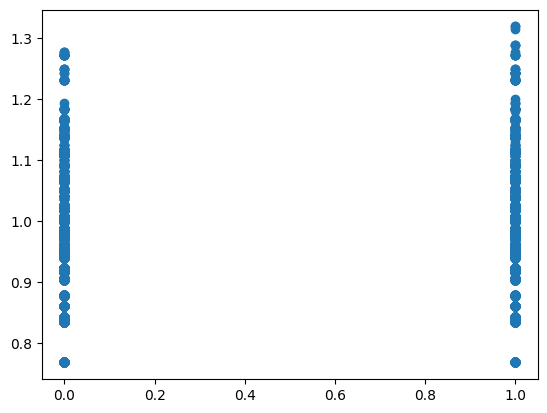

In [111]:
import matplotlib.pyplot as plt

plt.scatter(merged_data["depression"],merged_data["min_to_exp"])
plt.plot(merged_data[merged_data["depression"]]["min_to_exp"].mean())

In [112]:
merged_data["experienced"]

0        True
1        True
2        True
3        True
4       False
        ...  
6715     True
6716     True
6717     True
6718     True
6719     True
Name: experienced, Length: 6720, dtype: bool

In [113]:


_data = merged_data[merged_data["experienced"] == False].groupby(["participant_id","depressionCont"])["min_to_exp"].mean()
_data_depressionCont = np.array([[t0,t1] for t0,t1 in _data.index])[:,1]

ValueError: x and y must be the same size

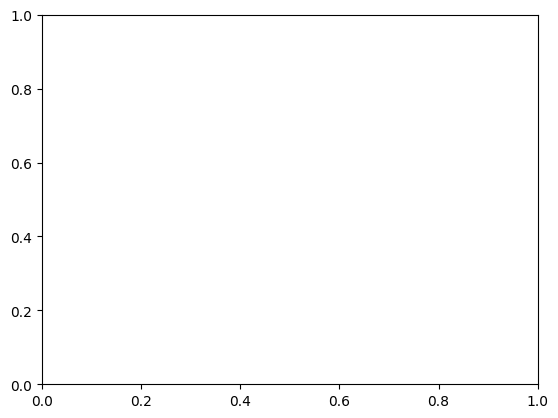

In [114]:
_data = merged_data.groupby(["participant_id","depressionCont"])["min_to_exp"].mean()

plt.scatter(_data_depressionCont,_data.values) 

In [109]:
np.corrcoef(_data_depressionCont,_data.values)

array([[1.        , 0.26973042],
       [0.26973042, 1.        ]])